# MS-Decoder Analysis

This Notebook's purpose is to analyze the MS-Decoder files, creating histograms for different parameters, ion series, low/high collision etc. 

In [72]:
import pandas as pd

samples = pd.read_excel('samples.xlsx', 'Isotope not necessarily lower')
samples.iloc[:10,:10]

,This is a Benchmark for the current version of the R4 decoder,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,This file has been generated: 2018-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,198 spectra have been decoded with 7 sets of p...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Paramaters # 1 m/z Tolerance: 0.05 / Int. thre...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,1_AOA-197-1-High_Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Paramaters # 1 m/z Tolerance: 0.05 / Int. thre...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,ASCII character,O,c,t,e,t,NaN,NaN,NaN
8,NaN,Tag on byte,0,G,A,C,T,NaN,NaN,NaN
9,NaN,Reference Code,01001111,01100011,01110100,01100101,01110100,NaN,NaN,NaN


This function gives us the box of cells in which a particular table of our excel file is present. For example, for parameter 1, molecule 1 and High energy, we must provide (0,0) (indexing begins from 0).

In [76]:
# samples.iloc[5:5+15 , 1:1+9]
def getTable(row, col):
    r = row*16 + 5
    c = col*10 + 1
    return samples.iloc[r:r+15 ,  c:c+9]

getTable(0,0)

,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
5,1_AOA-197-1-High_Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Paramaters # 1 m/z Tolerance: 0.05 / Int. thre...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ASCII character,O,c,t,e,t,NaN,NaN,NaN
8,Tag on byte,0,G,A,C,T,NaN,NaN,NaN
9,Reference Code,01001111,01100011,01110100,01100101,01110100,NaN,NaN,NaN
10,Series a,NaN,00011011,00101110,00011101,NaN,NaN,NaN,NaN
11,Series b,NaN,01100011,01110100,01100101,NaN,NaN,NaN,NaN
12,Series c,NaN,00000110,01010000,00001111,NaN,NaN,NaN,NaN
13,Series d,01001111,00110011,01010000,01010101,NaN,NaN,NaN,NaN
14,Series w,00111100,11010011,00011010,11011010,0,NaN,NaN,NaN


Now, we must process each block and get the histogram of that particular block. The histogram object will be of this shape: histo[tag][series]. Series will be numbered from 0-7, where 0 is for series a, and 7 is for series z.

In [58]:
def getTableHisto(tableRow, tableCol):
    table = getTable(tableRow, tableCol)
    
    histo = {}
    
    # Go column by column, starting from the column with tag "0"
    for i in range(1, 9):
        
        # This means that we do not have any more tags left  
        try:
            if str(type(table.iloc[3,i])) == "<type 'float'>":
                break
        except:
            print "i=" + str(i)
        
        if str(table.iloc[3,i]) == "Tag on byte":
            continue
            
        correctCode = str(table.iloc[4,i])
        tag = str(table.iloc[3,i])
        histo[tag] = [0, 0, 0, 0, 0, 0, 0, 0]
        
        for j in range(5, 13):
            if correctCode == table.iloc[j, i]:
                histo[tag][j-5] += 1
                
    return histo
getTableHisto(0,0)

{'0': [0, 0, 0, 1, 0, 0, 1, 1],
 'A': [0, 1, 0, 0, 0, 0, 0, 0],
 'C': [0, 1, 0, 0, 0, 0, 0, 0],
 'G': [0, 1, 0, 0, 0, 0, 0, 0],
 'T': [0, 0, 0, 0, 0, 0, 0, 0]}

### Congregating the histograms from all the tables

Call the function with j being the column of the tables we need the data for, and is_high_coll being True for high-energy collisions, False otherwise 

In [59]:
import numpy as np
def getHisto(j, is_high_coll):
    
    # Tables are laid out in (40 x 7)
    finalHisto = {}
    
    # If high-energy collision is needed, start from 0, otherwise 1   
    start = 1
    if(is_high_coll):
        start = 0
    
    for i in range(start, 40, 2):
        hist = getTableHisto(i,j)
        
        # Get the cumulative score        
        for tag, series in hist.items():
            if tag not in finalHisto:
                finalHisto[tag] = [0,0,0,0,0,0,0,0]

            finalHisto[tag] = np.add(finalHisto[tag], series)
    
    return finalHisto
    
# getHisto(0, True)


### Plotting the results

plot the result of the data, with the following parameters: column, isHighColl, tag

In [60]:
import matplotlib.pyplot as plt

column = 0
isHighColl = True
tag = 'G'

def plot(col, isHighColl, tag):
    hist = getHisto(column, isHighColl)
    y = hist[tag]
    x = ['series a', 'series b', 'series c', 'series d', 'series w', 'series x', 'series y', 'series z']

    plt.figure(figsize=(10,10))
    plt.xlabel('Series')
    plt.ylabel('Frequency')
    plt.title('Frequency of different series for tag=' + tag + " and column=" + str(column))
    plt.bar(x,y)
    plt.show()

### Calculating accuracy in percentages

This will keep track of the total number of observations (while discarding all the blank space), so that the accuracy of a given series can be calculated in percentage

In [61]:
def getTableTotal(tableRow, tableCol):
    table = getTable(tableRow, tableCol)
    
    histo = {}
    
    # Go column by column, starting from the column with tag "0"
    for i in range(1, 9):
        
        # This means that we do not have any more tags left  
        try:
            if str(type(table.iloc[3,i])) == "<type 'float'>":
                break
        except:
            print "i=" + str(i)
        
        if str(table.iloc[3,i]) == "Tag on byte":
            continue
            
        correctCode = str(table.iloc[4,i])
        tag = str(table.iloc[3,i])
        histo[tag] = [0, 0, 0, 0, 0, 0, 0, 0]
        
        for j in range(5, 13):
            if str(type(table.iloc[j,i])) == "<type 'float'>":
                continue
            if len(str(table.iloc[j,i])) != 8:
                continue
            histo[tag][j-5] += 1
                
    return histo
getTableTotal(10,0)

{'0': [0, 0, 0, 1, 0, 0, 0, 1],
 'A': [1, 1, 1, 1, 0, 1, 1, 0],
 'B': [0, 0, 1, 1, 1, 0, 1, 0],
 'C': [1, 1, 1, 1, 1, 1, 1, 0],
 'F': [1, 1, 1, 1, 1, 0, 1, 1],
 'G': [1, 1, 1, 1, 1, 1, 1, 1],
 'I': [0, 1, 1, 1, 0, 1, 0, 0],
 'T': [0, 1, 1, 1, 1, 1, 1, 1]}

### Congregating the totals from all the tables

In [62]:
def getTotal(j, is_high_coll):
    
    # Tables are laid out in (40 x 7)
    finalTotal = {}
    
    # If high-energy collision is needed, start from 0, otherwise 1   
    start = 1
    if(is_high_coll):
        start = 0
    
    for i in range(start, 40, 2):
        tot = getTableTotal(i,j)
        
        # Get the cumulative score        
        for tag, series in tot.items():
            if tag not in finalTotal:
                finalTotal[tag] = [0,0,0,0,0,0,0,0]

            finalTotal[tag] = np.add(finalTotal[tag], series)
    
    return finalTotal
    
getTotal(0, False)

{'0': array([ 0,  0,  0, 16, 16, 15, 14, 16]),
 'A': array([17, 17, 17, 17, 17, 16, 17, 17]),
 'B': array([1, 2, 2, 1, 1, 1, 1, 1]),
 'C': array([18, 17, 17, 17, 17, 18, 17, 16]),
 'F': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'G': array([15, 15, 15, 15, 15, 12, 14, 14]),
 'I': array([1, 0, 1, 1, 0, 0, 0, 0]),
 'T': array([17, 16, 17, 17, 17, 17, 17, 17]),
 'd': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'e': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'o': array([1, 1, 1, 1, 1, 1, 1, 1]),
 't': array([1, 1, 1, 1, 1, 1, 1, 1])}

Calculating the percentage accuracy for a particular column, high/low energy collision, and tag

In [63]:
column = 0
isHighColl = False
tag = '0'

finalHist = getHisto(column, isHighColl)[tag]
finalTot = getTotal(column, isHighColl)[tag]

print "Correct: " + str(finalHist)
print "Total: " + str(finalTot)

y = [0,0,0,0,0,0,0,0]
for i in range(8):
    if finalTot[i] != 0:
        y[i] = (float(finalHist[i]) / finalTot[i]) * 100.0


Correct: [ 0  0  0 13  1  0  5  2]
Total: [ 0  0  0 16 16 15 14 16]


Plotting this data ...

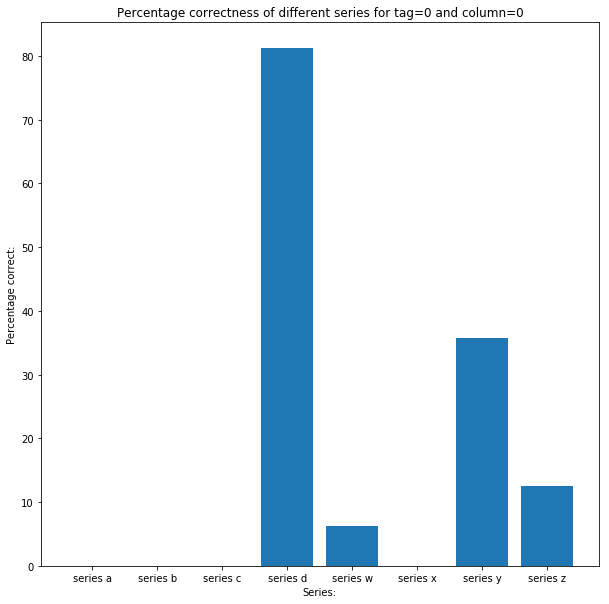

In [64]:
x = ['series a', 'series b', 'series c', 'series d', 'series w', 'series x', 'series y', 'series z']

plt.figure(figsize=(10,10))
plt.xlabel('Series:')
plt.ylabel('Percentage correct:')
plt.title('Percentage correctness of different series for tag=' + tag + " and column=" + str(column))
plt.bar(x,y)
plt.show()

# Part 2

### Calculating the number of correct observations for a particular 8-bit sequence, a particular tag, and a particular series

In [65]:
import binascii
def getTableHistoPart2(tableRow, tableCol):
    table = getTable(tableRow, tableCol)
    
    histo = {}
    
    # Go column by column, starting from the column with tag "0"
    for i in range(1, 9):
        
        # This means that we do not have any more tags left  
        try:
            if str(type(table.iloc[3,i])) == "<type 'float'>":
                break
        except:
            print "i=" + str(i)
        
        if str(table.iloc[3,i]) == "Tag on byte":
            continue
            
        correctCode = str(table.iloc[4,i])
#         correctCodeAscii = binascii.unhexlify('%x' % int(correctCode,2))
        tag = str(table.iloc[3,i])
        
        if correctCode not in histo:
            histo[correctCode] = {}
            
        histo[correctCode][tag] = np.array([0, 0, 0, 0, 0, 0, 0, 0])
        
        for j in range(5, 13):
            if correctCode == table.iloc[j, i]:
                histo[correctCode][tag][j-5] += 1
                
    return histo
getTableHistoPart2(0,4)

{'01001111': {'0': array([0, 0, 0, 0, 0, 0, 0, 0])},
 '01100011': {'G': array([0, 1, 0, 0, 0, 0, 0, 0])},
 '01100101': {'C': array([0, 1, 0, 0, 0, 0, 0, 0])},
 '01110100': {'A': array([0, 1, 0, 0, 0, 0, 0, 0]),
  'T': array([0, 0, 0, 0, 0, 0, 0, 0])}}

In [66]:
getTableHistoPart2(2,0)

{'01000011': {'0': array([0, 0, 0, 1, 0, 0, 0, 1])},
 '01100100': {'C': array([0, 1, 0, 0, 0, 0, 0, 0])},
 '01100101': {'T': array([0, 0, 0, 0, 0, 0, 1, 0])},
 '01101111': {'A': array([0, 1, 0, 1, 0, 0, 0, 0])}}

### Adding the histograms for all the tables ...

In [67]:
import binascii
def getHistoPart2(j, is_high_coll):
    
    # Tables are laid out in (40 x 7)
    finalHisto = {}
    
    # If high-energy collision is needed, start from 0, otherwise 1   
    start = 1
    if(is_high_coll):
        start = 0
    
    for i in range(start, 40, 2):
        hist = getTableHistoPart2(i,j)
        
        # Get the cumulative score        
        for seq, tag_ser in hist.items():
            
            # in case the sequence is not present, just add the tag_ser dictionary corresponding to that sequence in the final histo and continue to the next sequence
            if seq not in finalHisto:
                finalHisto[seq] = tag_ser
                continue
            
            # now we know that the sequence is present.
            for tag, ser in tag_ser.items():
                
                # if tag is not present in final histo
                if tag not in finalHisto[seq]:
                    finalHisto[seq][tag] = ser
                    continue
                    
                # now we know that the tag is present in that sequence
                finalHisto[seq][tag] = np.add(finalHisto[seq][tag], ser)
            
            
                
    
    return finalHisto
    
getHistoPart2(0, True)

{'0': {'C': array([0, 0, 0, 0, 0, 0, 0, 0]),
  't': array([0, 0, 0, 0, 0, 0, 0, 0])},
 '00100000': {'0': array([0, 0, 0, 0, 0, 0, 0, 0]),
  'A': array([2, 2, 1, 1, 0, 0, 0, 0]),
  'C': array([2, 2, 2, 2, 0, 0, 0, 0]),
  'G': array([3, 3, 1, 3, 0, 0, 0, 0]),
  'T': array([1, 2, 2, 0, 0, 1, 2, 0])},
 '00101100': {'0': array([0, 0, 0, 0, 0, 0, 0, 0]),
  'A': array([1, 1, 0, 0, 0, 0, 0, 0])},
 '00101110': {'A': array([0, 1, 0, 0, 0, 0, 0, 0]),
  'C': array([0, 0, 0, 0, 0, 0, 0, 0]),
  'T': array([0, 0, 0, 0, 0, 0, 1, 0])},
 '01000010': {'0': array([0, 0, 0, 1, 0, 0, 2, 0])},
 '01000011': {'0': array([0, 0, 0, 1, 0, 0, 0, 1])},
 '01000100': {'0': array([0, 0, 0, 1, 0, 0, 0, 0])},
 '01001111': {'0': array([0, 0, 0, 1, 0, 0, 1, 1])},
 '01010010': {'0': array([0, 0, 0, 0, 0, 0, 0, 0])},
 '01010011': {'0': array([0, 0, 0, 0, 0, 0, 0, 1])},
 '01100001': {'A': array([0, 1, 0, 0, 0, 0, 0, 0]),
  'T': array([0, 0, 0, 0, 0, 1, 1, 1])},
 '01100011': {'C': array([0, 2, 0, 0, 0, 0, 0, 0]),
  'G': array

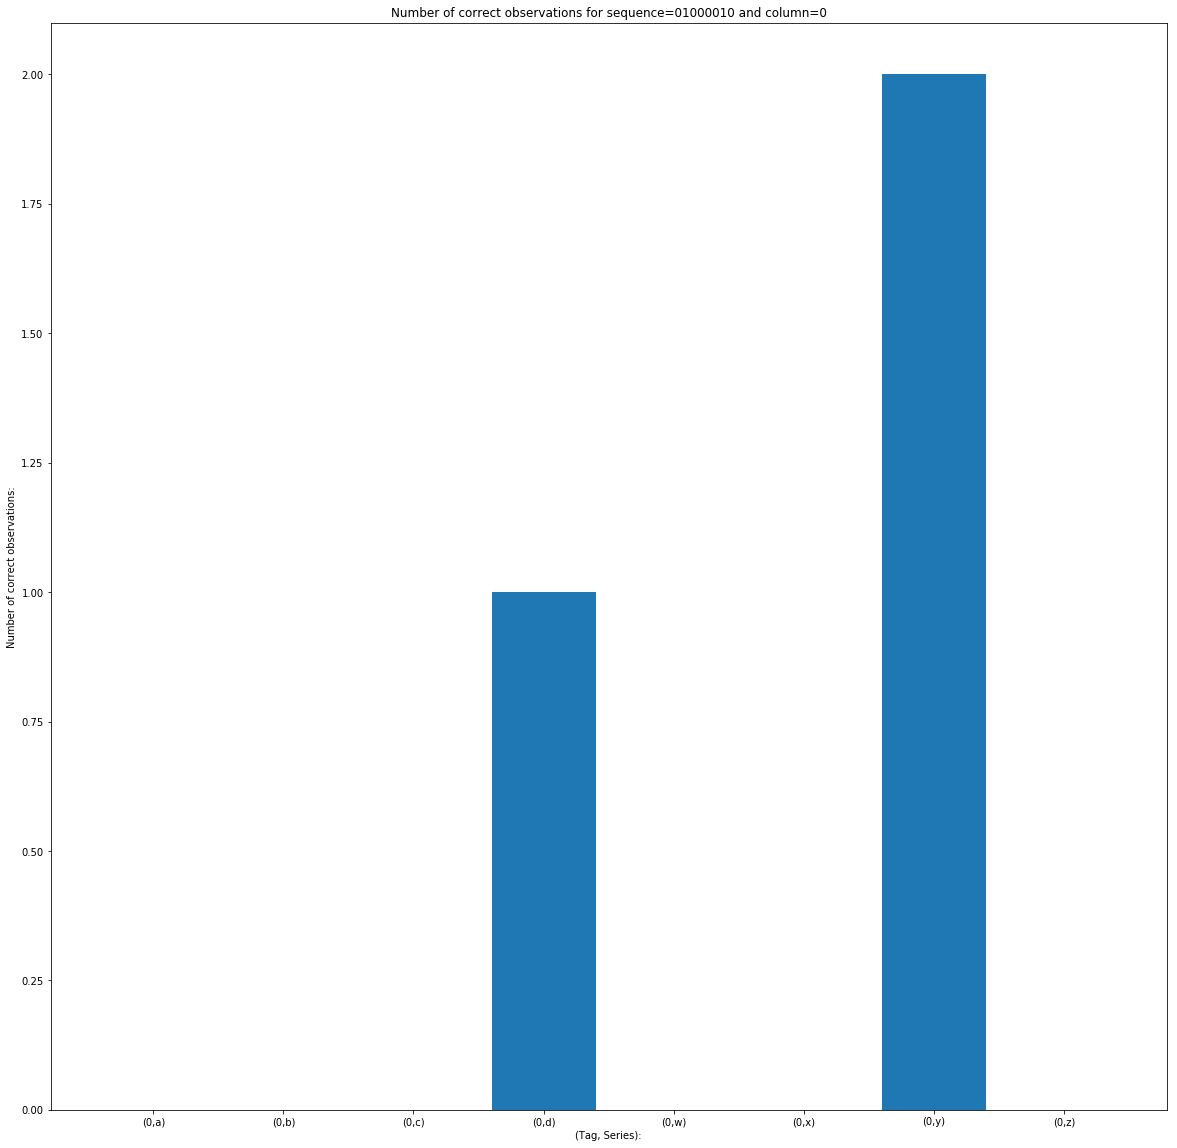

In [68]:
def plotSeqOnTag_Series(column, isHighColl, sequence):

    hist = getHistoPart2(column, isHighColl)

    # This fetches the dictionary for a particular sequence
    if sequence not in hist:
        print "Sorry the sequence is not in the table!"
        return
    
    hist = hist[sequence]
    
    x = []
    y = []
    
    serDict = {
        0: 'a',
        1: 'b',
        2: 'c',
        3: 'd',
        4: 'w',
        5: 'x',
        6: 'y',
        7: 'z'
    }
    
    for tag, ser in hist.items():
        for i in range(8):
            x.append('('+ tag + ',' + serDict[i] +')')
            y.append(ser[i])
            
    plt.figure(figsize=(20,20))
    plt.xlabel('(Tag, Series):')
    plt.ylabel('Number of correct observations:')
    plt.title('Number of correct observations for sequence=' + sequence + " and column=" + str(column))
    plt.bar(x,y)
    plt.show()
    

plotSeqOnTag_Series(0, True, '01000010')       
    

In [69]:
# All the functions:
getHisto(2, False) # Column, isHighCollision

# Plots
# plotSeqOnTag_Series(column, isHighColl, sequence)

{'0': array([0, 0, 0, 8, 1, 0, 2, 0]),
 'A': array([ 3, 16,  3,  3,  0,  0,  0,  0]),
 'B': array([0, 1, 0, 0, 0, 0, 0, 0]),
 'C': array([ 3, 16,  2,  2,  0,  0,  1,  0]),
 'F': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'G': array([ 3, 12,  0,  4,  0,  0,  0,  0]),
 'I': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'T': array([ 4, 13,  2,  2,  0,  0, 16,  4]),
 'd': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'e': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'o': array([0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([0, 0, 0, 0, 0, 0, 0, 0])}

In [70]:
def getHistoAllCols(is_high_coll):
    
    # Tables are laid out in (40 x 7)
    finalHisto = {}
    
    # If high-energy collision is needed, start from 0, otherwise 1   
    start = 1
    if(is_high_coll):
        start = 0
    
    for j in range(4):
        for i in range(start, 40, 2):
            hist = getTableHisto(i,j)

            # Get the cumulative score        
            for tag, series in hist.items():
                if tag not in finalHisto:
                    finalHisto[tag] = [0,0,0,0,0,0,0,0]

                finalHisto[tag] = np.add(finalHisto[tag], series)
    
    return finalHisto

In [71]:
getHistoAllCols(False)

{'0': array([ 0,  0,  0, 45,  4,  0, 15,  6]),
 'A': array([12, 66, 12,  8,  0,  4,  0,  0]),
 'B': array([0, 6, 0, 0, 0, 0, 0, 0]),
 'C': array([12, 62,  8,  8,  0,  0,  1,  0]),
 'F': array([0, 2, 0, 1, 0, 0, 0, 0]),
 'G': array([12, 57,  0, 16,  0,  0,  0,  0]),
 'I': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'T': array([16, 46,  8,  5,  0,  8, 64, 17]),
 'd': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'e': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'o': array([0, 0, 0, 0, 0, 0, 0, 0]),
 't': array([0, 0, 0, 0, 0, 0, 0, 0])}